<a href="https://colab.research.google.com/github/vietsub00/Perceiver_Notebook/blob/main/Perceiver_non_weight_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-addons
!pip install -q einops
!pip install -q --upgrade imgaug
!pip install -q tf-models-official

import numpy as np
from math import pi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from einops import rearrange, repeat
import official.vision.image_classification.augment as aug
import os
tf.random.set_seed(42)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

     |████████████████████████████████| 1.1 MB 4.7 MB/s 
     |████████████████████████████████| 948 kB 4.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 213 kB 56.6 MB/s 
     |████████████████████████████████| 47.7 MB 1.3 MB/s 
     |████████████████████████████████| 352 kB 58.8 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 4.9 MB 43.8 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.8 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
INFO:tensorflow:Deallocate tpu buffe

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.46.72.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.46.72.202:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Setup Hyperparameters:

In [2]:
path = 'baseline'
os.mkdir(path)

In [3]:
learning_rate = 0.002
weight_decay = 0.0000
batch_size = 256
num_epochs = 120
num_classes = 10
img_size = 32
input_axis = 2              # input axis 1 for audio/sequence data, 2 for image and 3 for 3D and/or video
input_channels = 3          # number of input channels: 3 for RGB image
num_freq_bands = 32         # number of freq bands, with original value (2 * K + 1)
max_freq = 16               # maximum frequency, hyperparameter depending on how fine the data is
data_dim = img_size**2      # shape of the image after flatten out
embedded_dim = (input_axis * (num_freq_bands * 2 + 1)) + input_channels   # Embedding size of each element in the data and latent arrays.
latent_dim = 16            # Size of the latent array.
projection_dim = 512
num_heads = 8         # Number of self-attentiom heads.
num_transformer_blocks = 4
num_iterations = 2    # Repetitions of the cross-attention and Transformer modules.
ffn_dropout_rate = 0.0      # dropout rate for feed forward network
attn_dropout_rate = 0.0     # dropout rate for cross attention module
ffn_units = [
    projection_dim,
    projection_dim,
    ]                 # Size of the Transformer Feedforward network.
classifier_units = [
    projection_dim,
    num_classes,
]                      # Size of the Feedforward network of the final classifier.
print('Embedded dimension: ', embedded_dim)
print('Projection dimension: ', projection_dim)

Embedded dimension:  133
Projection dimension:  512


## Load and apply Fourier encoding on the data:

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')
print(f'x_train shape: {x_test.shape}, y_train shape: {y_test.shape}')

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (40000, 32, 32, 3), y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3), y_val shape: (10000, 1)
x_train shape: (10000, 32, 32, 3), y_train shape: (10000, 1)


## Helper Functions:

In [5]:
def fourier_encode(x, max_freq, num_bands = 4):
  x = tf.expand_dims(x, -1)
  orig_x = x

  scales = tf.linspace(1., max_freq / 2, num_bands)
  # scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]
  scales = tf.reshape(scales, (1, 1, num_bands))

  x = x * scales * pi
  # x = 2. * np.pi * x * scales
  x = tf.concat([tf.sin(x), tf.cos(x)], axis = -1)
  x = tf.concat((orig_x, x), axis = -1)
  return x

In [6]:
class PixelFlatten(keras.layers.Layer): # flatten encoded images from shape (n, x, y, c) to (n, x*y, c)
  def __init__(self):
        super(PixelFlatten, self).__init__()
  def call(self, inputs):
        #return rearrange(inputs, "b ... d -> b (...) d")
        return rearrange(inputs, "b d ... -> (b d) ... ")

In [7]:
def feed_forward(hidden_units, activation='gelu', use_bias=True, dropout_rate=0.0, name=None):
    ffn = []

    for units in hidden_units[:-1]:
        ffn.append(layers.Dense(units, activation=activation, use_bias=use_bias))

    ffn.append(layers.Dense(units=hidden_units[-1], use_bias=use_bias))
    ffn.append(layers.Dropout(dropout_rate))

    ffn = tf.keras.Sequential(ffn, name=name)
    return ffn

### Cross-attention module
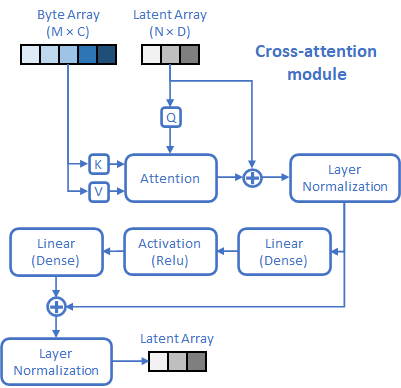
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
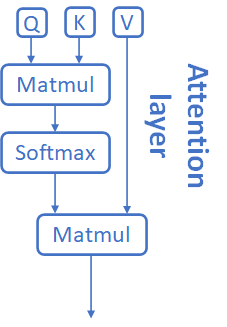

**we should consider adding input channels instead of projection dimension for the byte array**

In [8]:
def cross_attention_module(data_dim,
                           embedded_dim,
                           latent_dim,
                           projection_dim, 
                           ffn_units, 
                           ffn_dropout_rate = 0,
                           attn_dropout_rate = 0,
                           name = None
):
    ''' According to the paper, the latent array has shape (N, D), which 
    corresponding to shape (latent_dim, projection_dim) in this function'''

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, embedded_dim))
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization()(inputs["latent_array"])
    data_array = layers.LayerNormalization()(inputs["data_array"])

    # The queries, keys, and values have the same number of channels as the minimum of the input channels
    channels_num = min(embedded_dim, projection_dim)

    # Create query tensor: [1, latent_dim, channels_num].
    query = layers.Dense(units=channels_num)(latent_array)
    # Create key tensor: [batch_size, data_dim, channels_num].
    key = layers.Dense(units=channels_num)(data_array)
    # Create value tensor: [batch_size, data_dim, channels_num].
    value = layers.Dense(units=channels_num)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, channels_num].
    attn_output = layers.Attention(use_scale=True, dropout=attn_dropout_rate)(
        [query, key, value], return_attention_scores=False
    )
    
    # The output of attention is passed through an additional linear 
    # layer to project it to the same number of channels in the query inputs
    attn_output = layers.Dense(units=projection_dim)(attn_output)

    # Skip connection 1.
    attn_output = layers.Add()([attn_output, latent_array])
    # Apply layer norm.
    attn_output = layers.LayerNormalization()(attn_output)
    # Apply Feedforward network.
    ffn_output = feed_forward(hidden_units=ffn_units,
                              dropout_rate=ffn_dropout_rate,
                              name=name+'ff')(attn_output)
    # Skip connection 2.
    ffn_output = layers.Add()([ffn_output, attn_output])

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=ffn_output, name=name)
    return model

### Latent Transformer module

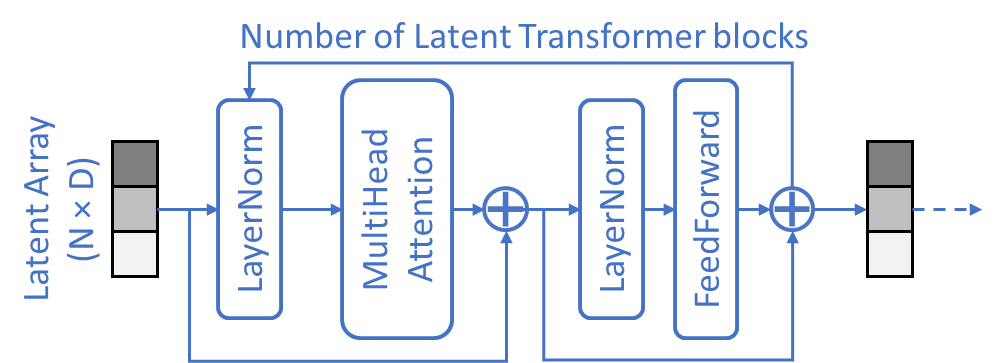

In [9]:
def latent_transformer_module(latent_dim,
                              projection_dim,
                              num_heads,
                              num_transformer_blocks,
                              ffn_units,
                              ffn_dropout_rate = 0,
                              attn_dropout_rate = 0,
                              name = None):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization()(x0)
        # Create a multi-head self-attention layer.
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, 
                                                key_dim=projection_dim, 
                                                dropout=attn_dropout_rate)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attn_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization()(x2)
        # Apply Feedforward network.
        x3 = feed_forward(hidden_units=ffn_units, dropout_rate=ffn_dropout_rate, name=name+str(_)+'ff')(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=x0, name=name)
    return model

## Perceiver class

In [10]:
class Perceiver(tf.keras.Model):
    def __init__(
        self,
        num_freq_bands,
        max_freq,
        data_dim,
        embedded_dim,
        latent_dim,
        projection_dim,
        num_heads, # Number of Latent Self Attention heads, 8 in paper
        num_transformer_blocks, # Number of Latent Transformer blocks
        num_iterations, # Depth of the network
        ffn_units,
        classifier_units,
        ffn_dropout_rate,
        attn_dropout_rate,
        share_weights = True       
    ):
        super(Perceiver, self).__init__()
        self.num_freq_bands = num_freq_bands
        self.max_freq = max_freq
        self.data_dim = data_dim
        self.embedded_dim = embedded_dim
        self.latent_dim = latent_dim
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.num_iterations = num_iterations
        self.ffn_units = ffn_units
        self.classifier_units = classifier_units
        self.ffn_dropout_rate = ffn_dropout_rate
        self.attn_dropout_rate = attn_dropout_rate
        self.share_weights = share_weights

        # Create latent array with shape [latent_dim, projection_dim], or (N, D) according to the paper
        initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer = initializer,
            trainable=True,
            name='LatentArray'
        )
        
        self.stacks = []
        for _ in range(self.num_iterations): # The repetition other than the first one share weights together
          self.stacks.append([cross_attention_module(self.data_dim,
                                                     self.embedded_dim,
                                                     self.latent_dim,
                                                     self.projection_dim,
                                                     self.ffn_units,
                                                     self.ffn_dropout_rate,
                                                     self.attn_dropout_rate,
                                                     name = 'CrossAttn' + str(_)
                                                     ), 
                              latent_transformer_module(self.latent_dim,
                                                        self.projection_dim,
                                                        self.num_heads,
                                                        self.num_transformer_blocks,
                                                        self.ffn_units,
                                                        self.ffn_dropout_rate,
                                                        self.attn_dropout_rate,
                                                        name = 'LatentTransformer' + str(_)
                                                        )])
          
          # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = feed_forward(hidden_units=self.classifier_units, 
                                                dropout_rate=self.ffn_dropout_rate, name='to_logits')

    def call(self, input):
        # # Append fourier encode to the inputs
        # print(input.get_shape())
        # enc_input = keras.layers.Concatenate(axis=-1)([input, self.enc_pos])
        # flatten_input = self.input_flatten(input)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": input,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for iteration in range(self.num_iterations):
            # Apply cross-attention between the latent array and the data array.
            latent_array = self.stacks[iteration][0](cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.stacks[iteration][1](latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        average = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(average)
        return tf.nn.softmax(logits)

## Image Augmentation & Fourier Encoding:

In [11]:
axis = [img_size, img_size]
axis_pos = list(map(lambda size: tf.linspace(-1.0, 1.0, num = size), axis))
pos = tf.stack(tf.meshgrid(*axis_pos, indexing = "ij"), axis = -1)

enc_pos = fourier_encode(pos, max_freq, num_freq_bands)
enc_pos = rearrange(enc_pos, "... n d -> ... (n d)")

flatten = PixelFlatten()

# Data Augmentation
rand_aug = aug.RandAugment(3, 8) 
Rot = keras.layers.experimental.preprocessing.RandomRotation(0.15)
Trans = keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15)
Flip = tf.keras.layers.experimental.preprocessing.RandomFlip(mode= 'horizontal')
Zoom = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1)
Contrast = tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)

AUTO = tf.data.experimental.AUTOTUNE

#Create dataset object
trainset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(
        lambda x, y: (tf.image.resize(x, (img_size, img_size)), y),
        num_parallel_calls=AUTO,
    )
    # .map(
    #     lambda x, y: (tf.cast(x, tf.uint8), y),
    #     num_parallel_calls=AUTO,
    #      )
    # .map(
    #     lambda x, y: (rand_aug.distort(x), y),
    #     num_parallel_calls=AUTO,
    #     )
    .map(
        lambda x, y: (Rot.call(x), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (Trans.call(x), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (Flip.call(x), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (Zoom.call(x), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (Contrast.call(x), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.cast(x, tf.float32), y),
        num_parallel_calls=AUTO,
         )
    .map(
        lambda x, y: (flatten.call(keras.layers.Concatenate(axis=-1)([x, enc_pos])), y),
        num_parallel_calls=AUTO,
         )
    .batch(batch_size)
    .prefetch(AUTO)
)

valset = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(
        lambda x, y: (tf.image.resize(x, (img_size, img_size)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.cast(x, tf.float32), y),
        num_parallel_calls=AUTO,
         )
    .map(
        lambda x, y: (flatten.call(keras.layers.Concatenate(axis=-1)([x, enc_pos])), y),
        num_parallel_calls=AUTO,
         )
    .batch(batch_size)
    .prefetch(AUTO)
)

testset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(
        lambda x, y: (tf.image.resize(x, (img_size, img_size)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (tf.cast(x, tf.float32), y),
        num_parallel_calls=AUTO,
         )
    .map(
        lambda x, y: (flatten.call(keras.layers.Concatenate(axis=-1)([x, enc_pos])), y),
        num_parallel_calls=AUTO,
         )
    .batch(batch_size)
    .prefetch(AUTO)
)

## Create model:

In [12]:
with strategy.scope():
  model = Perceiver(num_freq_bands,
                    max_freq,
                    data_dim,
                    embedded_dim,
                    latent_dim,
                    projection_dim,
                    num_heads,
                    num_transformer_blocks,
                    num_iterations,
                    ffn_units,
                    classifier_units,
                    ffn_dropout_rate,
                    attn_dropout_rate,
  )
  model.compile(optimizer=tfa.optimizers.LAMB(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
                          tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")]
                )

In [13]:
# Create a learning rate scheduler callback (reduce the learning rate when val_loss is not improve after 5 epochs: new_lr=lr*factor,)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5
)

# Create an early stopping callback. (Stop the training if the val_loss does not improve after 20 epochs)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=30, restore_best_weights=True
)

In [14]:
with strategy.scope():
  history = model.fit(trainset,
                      epochs = num_epochs,
                      callbacks = [reduce_lr, early_stopping],
                      validation_data = valset
                      )

Epoch 1/120
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


157/157 [==============================] - 158s 494ms/step - loss: 2.3197 - acc: 0.1848 - top5-acc: 0.6874 - val_loss: 1.9523 - val_acc: 0.2747 - val_top5-acc: 0.7955 - lr: 0.0020
Epoch 2/120
157/157 [==============================] - 23s 146ms/step - loss: 1.9364 - acc: 0.2797 - top5-acc: 0.8103 - val_loss: 1.9128 - val_acc: 0.2820 - val_top5-acc: 0.8143 - lr: 0.0020
Epoch 3/120
157/157 [==============================] - 23s 143ms/step - loss: 1.8417 - acc: 0.3196 - top5-acc: 0.8386 - val_loss: 1.8205 - val_acc: 0.3120 - val_top5-acc: 0.8526 - lr: 0.0020
Epoch 4/120
157/157 [==============================] - 23s 145ms/step - loss: 1.7823 - acc: 0.3430 - top5-acc: 0.8557 - val_loss: 1.7212 - val_acc: 0.3675 - val_top5-acc: 0.8705 - lr: 0.0020
Epoch 5/120
157/157 [==============================] - 23s 144ms/step - loss: 1.7208 - acc: 0.3673 - top5-acc: 0.8727 - val_loss: 1.6361 - val_acc: 0.3972 - val_top5-acc: 0.8862 - lr: 0.0020
Epoch 6/120
157/157 [==============================] - 2

In [15]:
model.save_weights(path+'/my_model.h5')
np.save(path+'/history.npy', history.history)

In [16]:
results = []
results.append(['Train:', model.evaluate(trainset)])
results.append(['Val:', model.evaluate(valset)])
results.append(['Test:', model.evaluate(testset)])

40/40 [==============================] - 4s 62ms/step - loss: 1.2170 - acc: 0.5808 - top5-acc: 0.9466


In [17]:
with open(path+'/results.txt', 'w') as f:
    for item in results:
        f.write("{} loss={}, acc={}, top5-acc={} \n".format(item[0], item[1][0], item[1][1], item[1][2]))
    f.close()

In [22]:
%%capture cap --no-stderr
display(model.summary())

with open(path+'/summary.txt', 'w') as f:
    f.write(cap.stdout)

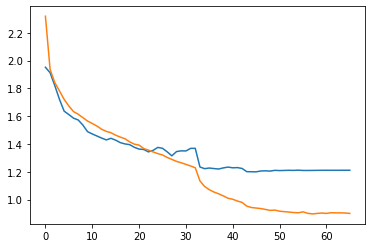

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

In [23]:
zippath = path+'.zip'

!zip -r "$zippath" "$path"

# from google.colab import files
# files.download(path+'.zip')

updating: baseline/ (stored 0%)
updating: baseline/summary.txt (deflated 79%)
updating: baseline/my_model.h5 (deflated 8%)
updating: baseline/history.npy (deflated 53%)
updating: baseline/results.txt (deflated 42%)


In [ ]:
# import time
# for i in range(100):
#     print('Something to keep kernel alive')
#     time.sleep(10)

Something to keep kernel alive
Something to keep kernel alive
Something to keep kernel alive
Something to keep kernel alive


In [ ]:
# with strategy.scope():
#   model = Perceiver(num_freq_bands,
#                     max_freq,
#                     data_dim,
#                     embedded_dim,
#                     latent_dim,
#                     projection_dim,
#                     num_heads,
#                     num_transformer_blocks,
#                     num_iterations,
#                     ffn_units,
#                     classifier_units,
#                     ffn_dropout_rate,
#                     attn_dropout_rate,
#   )
#   model.compile(optimizer=tfa.optimizers.LAMB(learning_rate=learning_rate),
#                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
#                           tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")]
#                 )
  
# model(np.zeros((1,1024,embedded_dim)))
# model.load_weights('my_model.h5')
# model.evaluate(testset)